In [3]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model

In [4]:
def preprocess(images):
    """Normalizes the images and reshapes it into batches."""
    print('images shape before:', images.shape)
    images = images.astype("float32") / 255.0
    images = images.reshape((-1, 28, 28, 1))
    print('images shape after:', images.shape)
    return images

In [15]:
def noise(images):
    """Adds random noise to each image."""
    noise_factor = 0.4
    noise_ = noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=images.shape
    )
    print('noise shape:', noise_.shape)
    noisy_images = images + noise_
    print('noisy_images shape:', noisy_images.shape)
    return np.clip(noisy_images, 0.0, 1.0)

In [16]:
def display(images01, images02, n = 10):
    """Displays N random images from each array."""
    indices = np.random.randint(len(images01), size=n)
    images01_batch = images01[indices, :]
    images02_batch = images02[indices, :]

    print('indices shape:', indices.shape)
    print('images01_batch shape:', images01_batch.shape)
    print('images02_batch shape:', images02_batch.shape)

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images01_batch, images02_batch)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [19]:
# Preprocess the data
# Load the mnist dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [20]:
# Normalize and reshape the data
x_train = preprocess(x_train)
x_test = preprocess(x_test)

images shape before: (60000, 28, 28)
images shape after: (60000, 28, 28, 1)
images shape before: (10000, 28, 28)
images shape after: (10000, 28, 28, 1)


In [21]:
# Create a copy of the data with added noise
x_train_noisy = noise(x_train)
x_test_noisy = noise(x_test)

noise shape: (60000, 28, 28, 1)
noisy_images shape: (60000, 28, 28, 1)
noise shape: (10000, 28, 28, 1)
noisy_images shape: (10000, 28, 28, 1)


indices shape: (10,)
images01_batch shape: (10, 28, 28, 1)
images02_batch shape: (10, 28, 28, 1)


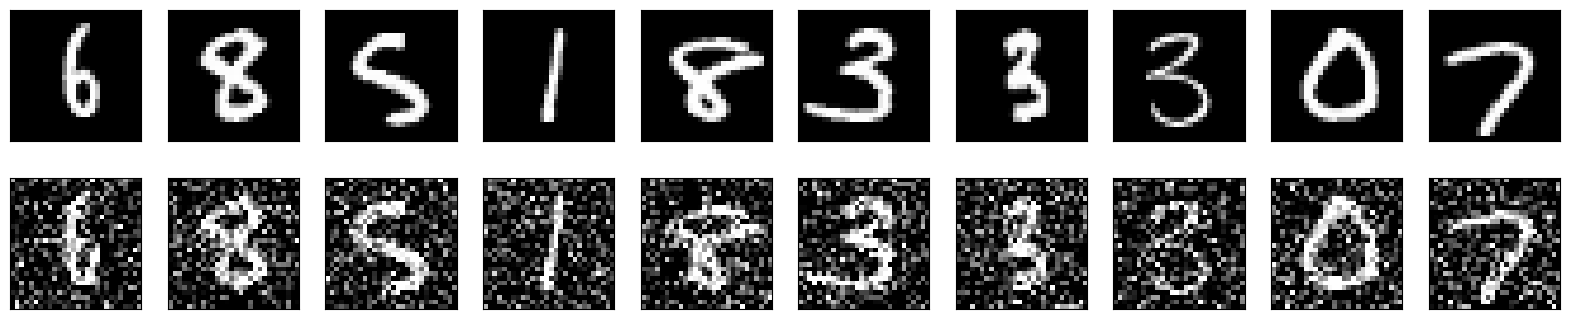

In [22]:
# Display the train data and a version of it with added noise
display(x_train, x_train_noisy)

In [23]:
# Build the autoencoder
inputs = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
outputs = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        9248  

In [24]:
# Train the auto-encoder
# Train it using the noisy data as our input and the clean data as our target. 
# We want our autoencoder to learn how to denoise the images.
autoencoder.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
)

Epoch 1/100
469/469 [==============================] - 15s 32ms/step - loss: 0.1798 - val_loss: 0.1053
Epoch 2/100
469/469 [==============================] - 15s 32ms/step - loss: 0.1014 - val_loss: 0.0976
Epoch 3/100
469/469 [==============================] - 15s 33ms/step - loss: 0.0970 - val_loss: 0.0948
Epoch 4/100
469/469 [==============================] - 16s 34ms/step - loss: 0.0947 - val_loss: 0.0930
Epoch 5/100
469/469 [==============================] - 16s 34ms/step - loss: 0.0932 - val_loss: 0.0918
Epoch 6/100
469/469 [==============================] - 16s 35ms/step - loss: 0.0921 - val_loss: 0.0908
Epoch 7/100
469/469 [==============================] - 16s 35ms/step - loss: 0.0912 - val_loss: 0.0901
Epoch 8/100
469/469 [==============================] - 15s 33ms/step - loss: 0.0905 - val_loss: 0.0895
Epoch 9/100
469/469 [==============================] - 15s 32ms/step - loss: 0.0900 - val_loss: 0.0890
Epoch 10/100
469/469 [==============================] - 15s 33ms/step - l

313/313 [==============================] - 2s 5ms/step
indices shape: (10,)
images01_batch shape: (10, 28, 28, 1)
images02_batch shape: (10, 28, 28, 1)


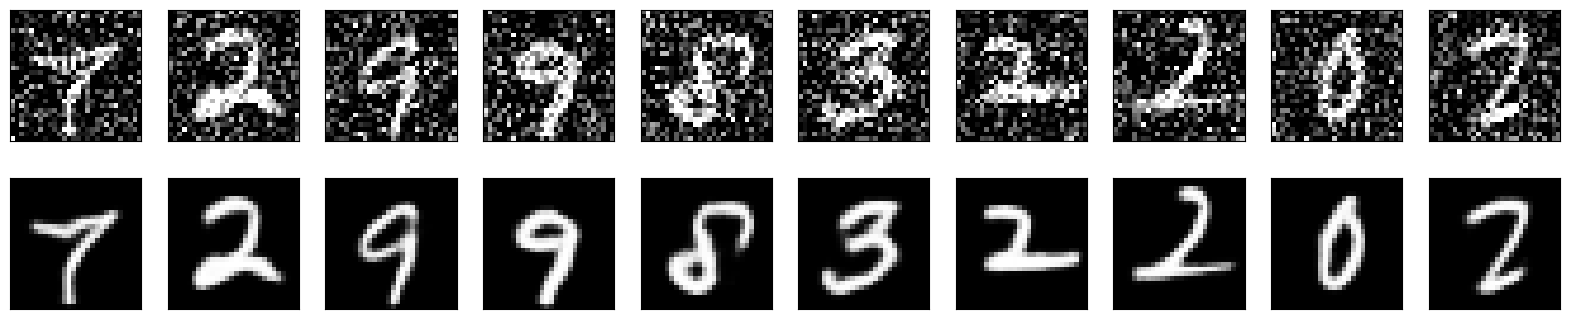

In [25]:
# Predict / Denoise
predictions = autoencoder.predict(x_test_noisy)
# Show results
display(x_test_noisy, predictions)